<!-- Centered layout with a university logo -->
<div align="center">

  <!-- University Logo -->
  <img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" width="180" height="180" style="margin-bottom: 10px;">
  
  <!-- Assignment Title -->
  <h1></h1>
  <h1 style="color:#0F5298; font-size: 40px; font-weight: bold; margin-bottom: 5px;">Deep Reinforcement Learning</h1>
  <h2 style="color:#0F5298; font-size: 32px; font-weight: normal; margin-top: 0px;">Assignment 06 - Multi-Armed and Contextual Bandits</h2>

  <!-- Department and University -->
  <h3 style="color:#696880; font-size: 24px; margin-top: 20px;">Computer Engineering Department</h3>
  <h3 style="color:#696880; font-size: 22px; margin-top: -5px;">Sharif University of Technology</h3>

  <!-- Semester -->
  <h3 style="color:#696880; font-size: 22px; margin-top: 20px;">Spring 2025</h3>

  <!-- Authors -->
  <h3 style="color:green; font-size: 22px; margin-top: 20px;">Full name: [Ayeen Poostforoushan]</h3>
  <h3 style="color:green; font-size: 22px; margin-top: 20px;">Student ID: [401105742]</h3>

  <!-- Horizontal Line for Separation -->
  <hr style="border: 1px solid #0F5298; width: 80%; margin-top: 30px;">

</div>


## Setup & Overview  
In this notebook, we simulate bandit problems using *MAB* (Multi-Armed Bandit) and *CtxBnd* (Contextual Bandit) frameworks.  
We compare several agents:
- **Oracle** (with privileged info)
- **RndAg** (Random Agent)
- **ExpFstAg** (Explore-First Agent)
- **UCB_Ag** (UCB Agent)
- **EpsGdAg** (Epsilon-Greedy Agent)
- **LinUCB_Ag** (LinUCB for contextual bandits)


Follow the instructions carefully and complete the sections marked with **TODO**.

## Setup and Environment

In the upcoming cells, we import necessary libraries, set up utility functions for reproducibility and plotting, and define the basic components of our bandit experiments.


In [1]:
# %% [code]
import numpy as np
import random
import time
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from dataclasses import dataclass
from copy import deepcopy
from tqdm.notebook import tqdm

plt.rcParams['figure.dpi'] = 100

In [2]:
# %% [code]
def plot_logs(df, x_key, y_key, legend_key, **kwargs):
    num = len(df[legend_key].unique())
    pal = sns.color_palette("hls", num)
    if 'palette' not in kwargs:
        kwargs['palette'] = pal
    ax = sns.lineplot(x=x_key, y=y_key, data=df, hue=legend_key, **kwargs)
    return ax

def set_seed(s):
    np.random.seed(s)
    random.seed(s)

set_seed(0)

## MAB Overview  
We consider a bandit with 10 arms. Two formulations:  
- **Stochastic:** Each arm gives a reward of 1 with probability *p*.  
- **Deterministic:** Each arm always returns a fixed reward.  
  
We'll work with the stochastic case. The reward probabilities will be set randomly.

In [3]:
# %% [code]
nArms = 10
p_arr = [np.random.random() for _ in range(nArms)]
print("Probabilities:", p_arr)

Probabilities: [0.5488135039273248, 0.7151893663724195, 0.6027633760716439, 0.5448831829968969, 0.4236547993389047, 0.6458941130666561, 0.4375872112626925, 0.8917730007820798, 0.9636627605010293, 0.3834415188257777]


**Q:** How might the performance of different agents change if the distribution of probabilities were not uniform?  

**A:** If the probabilities were more biased towards lower or higher probabilities and werent uniform, some of the agents that were more biased to estimate lower or higher expected rewards for arms would work incorrectly.


In [4]:
# %% [code]
@dataclass
class MAB_Env:
    p_arr: np.ndarray

    def step(self, act):
        return 1 if np.random.random() < self.p_arr[act] else 0

**Q:** Why does the MAB environment use a simple binary reward mechanism (1 or 0)?

**A:** This is just to model a simple environment where it's like a pill given works or not.

In [5]:
# %% [code]
@dataclass
class MAB_Eng:
    p_arr: np.ndarray
    max_steps: int
    agent: any

    def __post_init__(self):
        self.env = MAB_Env(p_arr=self.p_arr)

    def run(self, n_runs=1):
        logs = []
        for _ in tqdm(range(n_runs), desc='Runs'):
            run_rewards = []
            run_acts = []
            self.agent.reset()
            for t in range(self.max_steps):
                act = self.agent.get_action()
                rew = self.env.step(act)
                self.agent.update_Q(act, rew)
                run_acts.append(act)
                run_rewards.append(rew)
            logs.append(pd.DataFrame({
                'reward': run_rewards,
                'action': run_acts,
                'step': np.arange(len(run_rewards))
            }))
        return pd.concat(logs, ignore_index=True)

In [6]:
# %% [code]
def mab_swp(agents, p_arr, labels, n_runs=2000, max_steps=500):
    all_logs = []
    for idx, agent in enumerate(tqdm(agents, desc="Alg Sweeps")):
        engine = MAB_Eng(p_arr=p_arr, max_steps=max_steps, agent=agent)
        log_df = engine.run(n_runs)
        log_df['Alg'] = labels[idx]
        all_logs.append(log_df)
    return pd.concat(all_logs, ignore_index=True)

## Oracle Agent  
The **Oracle** has full knowledge of *p_arr*.  
**Question:** What is the maximum expected per-step reward?

**A:** It's the highest expected return of a band.

In [7]:
oracleReward = np.array(p_arr).max()
print(f'Max possible reward (Simple): {oracleReward}')

Max possible reward (Simple): 0.9636627605010293


**Q:** What insight does the oracle reward give us about the best possible performance?

**A:** It tells us that if we had the best agent to choose the best arm, what reward would we get. So we can compare our later agents with it.

-------------------

**Q:** Why is the oracle considered “cheating” in a practical sense?  

**A:** Because we don't have the real distributions of the rewards of the arms in the environment (here the 'P's of the bernoulli) in the real scenarios.

## RndAg (Random Agent)  
This agent selects an action at random at every timestep. It does no learning.


In [8]:
@dataclass
class RndAg:
    n_act: int

    def __post_init__(self):
        self.reset()

    def reset(self):
        self.t = 0
        self.act_counts = np.zeros(self.n_act, dtype=int)
        self.Q = np.zeros(self.n_act, dtype=float)

    def update_Q(self, act, rew):
        pass  # No learning

    def get_action(self):
        self.t += 1
        # TODO: get a random action index [Simple]
        sel_act = np.random.randint(0, self.n_act)
        return sel_act

Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-2-cea5b34d9fd8>:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(x=x_key, y=y_key, data=df, hue=legend_key, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subs

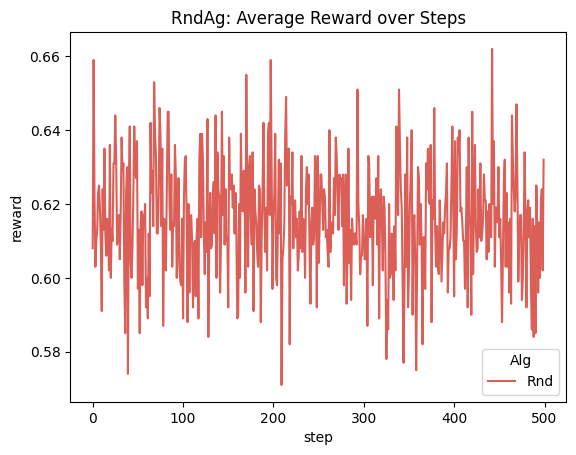

In [9]:
# %% [code]
rnd_agent = RndAg(n_act=len(p_arr))
n_runs = 1000
rnd_log = mab_swp([rnd_agent], p_arr, ['Rnd'], n_runs=n_runs)
# %% [code]
plot_logs(rnd_log, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', ci=None)
plt.title("RndAg: Average Reward over Steps")
plt.show()

**Q:** Why is the reward of the random agent generally lower and highly variable?

**A:** Because it's just randomly selecting the arms and therefore there is so many times where the best action is not selected and it's variable.

------------

**Q:** How might you improve a random agent without using any learning mechanism?

**A:** without having P, and without learning and using the results of the past rewards there is no way you can learn which action is better, because you have no feedback at all.

<ipython-input-2-cea5b34d9fd8>:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(x=x_key, y=y_key, data=df, hue=legend_key, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subs

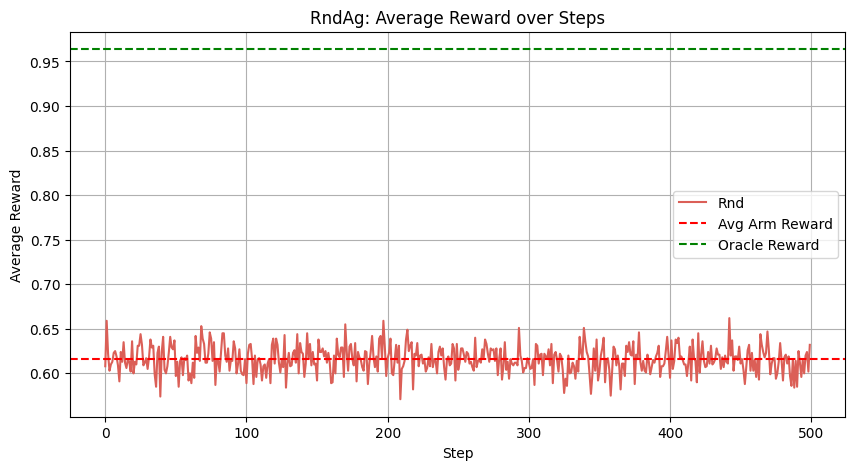

In [10]:
# TODO: Plot RndAg reward curve and average reward of all arms (Simple)
plt.figure(figsize=(10, 5))
plot_logs(rnd_log, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', ci=None)

# Plot the average of all arm probabilities as a horizontal line
avg_p = np.mean(p_arr)
plt.axhline(avg_p, color='red', linestyle='--', label='Avg Arm Reward')
plt.axhline(oracleReward, color='green', linestyle='--', label='Oracle Reward')


plt.title("RndAg: Average Reward over Steps")
plt.ylabel("Average Reward")
plt.xlabel("Step")
plt.legend()
plt.grid(True)
plt.show()

**Analysis:**  
- The x-axis shows the number of steps; y-axis shows average reward.  
- Regret is the gap between Oracle and agent performance.

## ExpFstAg (Explore-First Agent)  
This agent explores randomly for the first *max_ex* steps, then exploits the best arm thereafter.

In [11]:
@dataclass
class ExpFstAg:
    n_act: int
    max_ex: int

    def __post_init__(self):
        self.reset()

    def reset(self):
        self.t = 0
        self.act_counts = np.zeros(self.n_act, dtype=int)
        self.Q = np.zeros(self.n_act, dtype=float)

    def update_Q(self, act, rew):
        # Incremental average update
        self.act_counts[act] += 1
        alpha = 1 / self.act_counts[act]
        self.Q[act] += alpha * (rew - self.Q[act])

    def get_action(self):
        self.t += 1
        if self.t <= self.max_ex:
            # Random exploration
            sel_act = np.random.randint(0, self.n_act)
        else:
            # Exploit: choose the best arm
            sel_act = np.argmax(self.Q)
        return sel_act


### Run ExpFstAg with max_ex = 5  
We will test ExpFstAg (with 5 exploration steps) over 1000 runs and 500 steps.

Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-2-cea5b34d9fd8>:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(x=x_key, y=y_key, data=df, hue=legend_key, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subs

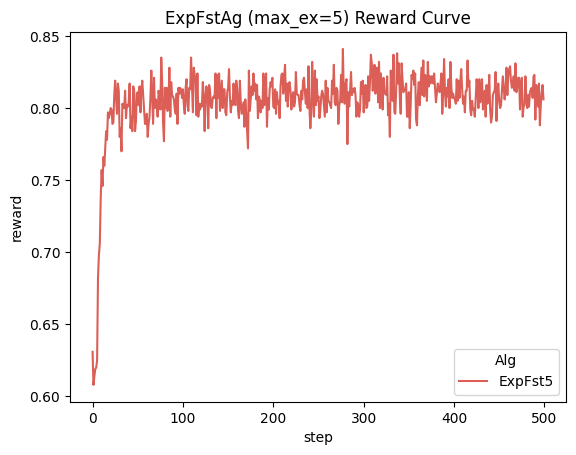

In [12]:
# %% [code]
max_ex = 5
expfst_agent = ExpFstAg(n_act=len(p_arr), max_ex=max_ex)
expfst_log = mab_swp([expfst_agent], p_arr, [f'ExpFst{max_ex}'], n_runs=1000, max_steps=500)
plot_logs(expfst_log, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', ci=None)
plt.title(f"ExpFstAg (max_ex={max_ex}) Reward Curve")
plt.show()

**Analysis:**  
- The ExpFstAg should outperform RndAg by identifying the best arm during exploration.  
- However, with too short exploration, it may miss the best arm.

----------

**Q:** Why might the early exploration phase (e.g., 5 steps) lead to high fluctuations in the reward curve?


**A:** Because the short exploration phase has high variance and different rewards in the first insignificant number of steps might cause a bad estimate of the action mean rewards. So it would cause the entire exploitation phase to work wrongly.

------------
**Q:** What are the trade-offs of using a fixed exploration phase?


**A:**
A fixed exploration phase balances simplicity with risk: it ensures each arm is initially sampled, but the quality of those early estimates heavily depends on the number of exploration steps. If the phase is too short, the agent may commit to suboptimal arms based on noisy data; if too long, it wastes time on poor options, increasing regret.

Alg Sweeps:   0%|          | 0/5 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-2-cea5b34d9fd8>:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(x=x_key, y=y_key, data=df, hue=legend_key, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subs

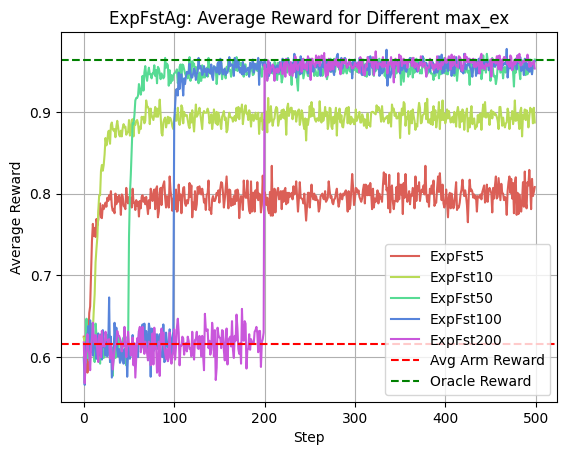

In [13]:
# %% [code]

# TODO: Run ExpFstAg for various max_ex values: [5, 10, 50, 100, 200] (Simple)
max_ex_list = [5, 10, 50, 100, 200]
agents = [ExpFstAg(n_act=len(p_arr), max_ex=ex) for ex in max_ex_list]
labels = [f'ExpFst{ex}' for ex in max_ex_list]

expfst_logs = mab_swp(agents, p_arr, labels, n_runs=1000, max_steps=500)
plot_logs(expfst_logs, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', ci=None)
plt.axhline(np.mean(p_arr), color='red', linestyle='--', label='Avg Arm Reward')
plt.axhline(np.max(p_arr), color='green', linestyle='--', label='Oracle Reward')
plt.title("ExpFstAg: Average Reward for Different max_ex")
plt.xlabel("Step")
plt.ylabel("Average Reward")
plt.legend()
plt.grid(True)
plt.show()


**Observations:**  
- Short exploration (e.g., 5 or 10 steps) may not reliably find the best arm.  
- Longer exploration (e.g., 50 or 100 steps) improves performance but may delay exploitation.

**Q:** How does increasing `max_ex` affect the convergence of the agent’s performance?


**A:** With 5 and 10 `max_ex`, we couldn't find the optimal action and got a worse average reward. But after increasing it to 50, we got the average reward sum of the oracle reward approx. And increasing it to 100 or 200 didn't have much effect.

------------------------------

**Q:** In real-world scenarios, what challenges might arise in selecting the optimal exploration duration?

**A:** The challenge is that we first don't know how many exploration steps might be needed. And setting it too high may result in excess regret. But if it is set too low, we might not estimate the correct rewards.

## UCB_Ag (UCB Agent)  
UCB dynamically balances exploration and exploitation by adding an exploration bonus to Q-values.

In [14]:
@dataclass
class UCB_Ag:
    n_act: int

    def __post_init__(self):
        self.reset()

    def reset(self):
        self.t = 0
        self.act_counts = np.zeros(self.n_act, dtype=int)
        self.Q = np.zeros(self.n_act, dtype=float)

    def update_Q(self, act, rew):
        # Incremental average update
        self.act_counts[act] += 1
        alpha = 1 / self.act_counts[act]
        self.Q[act] += alpha * (rew - self.Q[act])

    def get_action(self):
        self.t += 1
        delta = 1e-5  # to avoid division by zero
        bonus = np.sqrt(np.log(self.t) / (self.act_counts + delta))
        Q_explore = self.Q + bonus
        sel_act = np.random.choice(np.flatnonzero(Q_explore == Q_explore.max()))
        return sel_act


Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-2-cea5b34d9fd8>:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(x=x_key, y=y_key, data=df, hue=legend_key, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subs

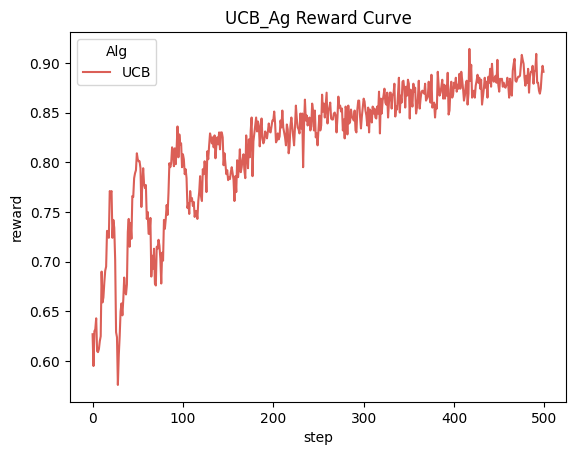

In [15]:
# %% [code]
ucb_agent = UCB_Ag(n_act=len(p_arr))
ucb_log = mab_swp([ucb_agent], p_arr, ['UCB'], n_runs=1000, max_steps=500)
plot_logs(ucb_log, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', ci=None)
plt.title("UCB_Ag Reward Curve")
plt.show()

**Q:** Under what conditions might an explore-first strategy outperform UCB, despite UCB’s theoretical optimality?

**A:** If one of the arms is by far better than the others, a simple short exploration in the explore-first strategy would be fine and have less regret.
Or maybe in the scenarios with short time horizon, maybe the explore-first would give only enough exploration and find the optimal action with less regret.

-----------------
**Q:** How do the design choices of each algorithm affect their performance in short-term versus long-term scenarios?

**A:** Explore-first focuses exploration early, which can perform well short-term if the best arm is easy to identify. UCB spreads exploration over time, which may hurt short-term but helps long-term by gradually refining estimates and reducing regret.

## UCB vs. ExpFstAg  
Now we compare UCB_Ag and ExpFstAg (with max_ex = 5) side by side.


**Question:**  
Why does UCB learn slowly (even after 500 steps, not reaching maximum reward)?  
*Hint:* Consider the conservative nature of the exploration bonus.

**A:** Because after being confident that an action is the optimal action, it is better to fully exploit it from then. And explore first does this if the optimal action is found in the exploration phase. But in the UCB, because of the exploration reward, it might still continue on exploring after 500 steps.


Alg Sweeps:   0%|          | 0/2 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-2-cea5b34d9fd8>:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(x=x_key, y=y_key, data=df, hue=legend_key, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subs

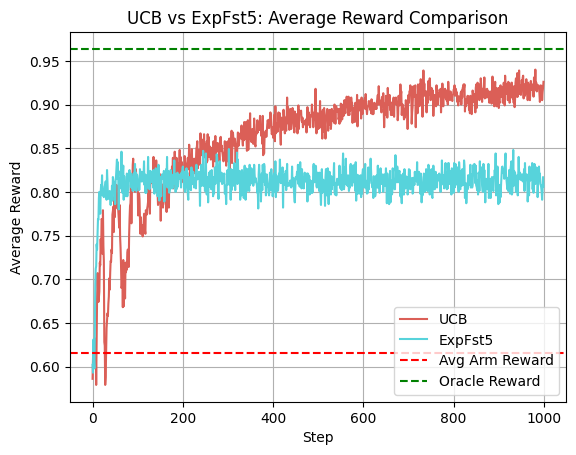

In [16]:
# %% [code]
agents = [
    UCB_Ag(n_act=len(p_arr)),
    ExpFstAg(n_act=len(p_arr), max_ex=5)
]
labels = ['UCB', 'ExpFst5']
comparison_logs = mab_swp(agents, p_arr, labels, n_runs=1000, max_steps=1000)

plot_logs(comparison_logs, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', ci=None)
plt.axhline(np.mean(p_arr), color='red', linestyle='--', label='Avg Arm Reward')
plt.axhline(np.max(p_arr), color='green', linestyle='--', label='Oracle Reward')
plt.title("UCB vs ExpFst5: Average Reward Comparison")
plt.xlabel("Step")
plt.ylabel("Average Reward")
plt.legend()
plt.grid(True)
plt.show()

**Question:**  
What happens if we let ExpFstAg explore for 20 steps? Compare its reward to UCB.

Alg Sweeps:   0%|          | 0/2 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-2-cea5b34d9fd8>:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(x=x_key, y=y_key, data=df, hue=legend_key, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subs

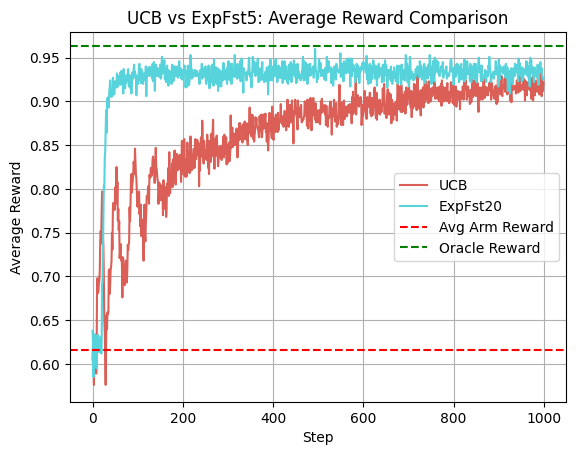

In [17]:
# %% [code]
agents = [
    UCB_Ag(n_act=len(p_arr)),
    ExpFstAg(n_act=len(p_arr), max_ex=20)
]
labels = ['UCB', 'ExpFst20']
comparison_logs = mab_swp(agents, p_arr, labels, n_runs=1000, max_steps=1000)

plot_logs(comparison_logs, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', ci=None)
plt.axhline(np.mean(p_arr), color='red', linestyle='--', label='Avg Arm Reward')
plt.axhline(np.max(p_arr), color='green', linestyle='--', label='Oracle Reward')
plt.title("UCB vs ExpFst5: Average Reward Comparison")
plt.xlabel("Step")
plt.ylabel("Average Reward")
plt.legend()
plt.grid(True)
plt.show()

**Q:** What impact does increasing the exploration phase to 20 steps have compared to 5 steps?

**A:** The extended exploration causes the agent to gather more accurate estimates of the arms' rewards, reducing the chance of committing to a suboptimal arm. This can improve long-term performance and in this case, performs better than UCB in the 1000 steps.

---------------

**Q:** How can you determine the optimal balance between exploration and exploitation in practice?

**A:** In practice, the optimal balance is often found through empirical tuning or using adaptive strategies. This can include cross-validation over different exploration hyper params, Also some observations can help us to finding it. If the real mean rewards were far from the estimated ones, we need more exploration steps.

**Q:** We know that UCB is optimal. Why might ExpFstAg perform better in practice?  
**A:** As mentioned earlier, in limited horizon settings or when one arm is clearly better, ExpFstAg can outperform UCB because it focuses on quick identification and early exploitation. While UCB is theoretically optimal in the long run, its ongoing exploration can lead to higher regret in finite-time scenarios. With proper hyperparameter tuning (e.g., choosing a suitable exploration length), ExpFstAg can balance exploration and exploitation more effectively in practice.

## Skewed Arms Scenario  
We now consider a skewed probability distribution where one arm is significantly better.

Alg Sweeps:   0%|          | 0/2 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-2-cea5b34d9fd8>:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(x=x_key, y=y_key, data=df, hue=legend_key, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subs

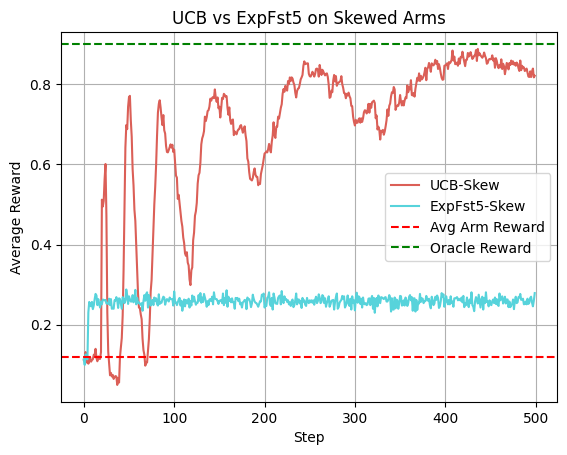

In [18]:
# %% [code]
skewed_p = [0.1, 0.2, 0.15, 0.21, 0.3, 0.05, 0.9, 0.13, 0.17, 0.07,
            0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

agents = [
    UCB_Ag(n_act=len(skewed_p)),
    ExpFstAg(n_act=len(skewed_p), max_ex=5)
]
labels = ['UCB-Skew', 'ExpFst5-Skew']
skewed_logs = mab_swp(agents, skewed_p, labels, n_runs=1000, max_steps=500)

plot_logs(skewed_logs, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', ci=None)
plt.axhline(np.mean(skewed_p), color='red', linestyle='--', label='Avg Arm Reward')
plt.axhline(np.max(skewed_p), color='green', linestyle='--', label='Oracle Reward')
plt.title("UCB vs ExpFst5 on Skewed Arms")
plt.xlabel("Step")
plt.ylabel("Average Reward")
plt.legend()
plt.grid(True)
plt.show()


**Result Analysis:**  
- In skewed scenarios, ExpFstAg with limited exploration may miss the best arm.  
- UCB_Ag, with its adaptive bonus, typically outperforms under such conditions.

## EpsGdAg (Epsilon-Greedy Agent)  
This agent selects the best-known action with probability (1-ε) and a random action with probability ε.

In [19]:
@dataclass
class EpsGdAg:
    n_act: int
    eps: float = 0.1

    def __post_init__(self):
        self.reset()

    def reset(self):
        self.act_counts = np.zeros(self.n_act, dtype=int)
        self.Q = np.zeros(self.n_act, dtype=float)

    def update_Q(self, act, rew):
        self.act_counts[act] += 1
        self.Q[act] += (1.0 / self.act_counts[act]) * (rew - self.Q[act])

    def get_action(self):
        if np.random.random() < self.eps:
            # Choose random action with probability eps
            sel_act = np.random.randint(0, self.n_act)
        else:
            # Choose the best estimated action
            sel_act = np.random.choice(np.flatnonzero(self.Q == self.Q.max()))
        return sel_act


**Analysis:**  
- Lower ε values favor exploitation, yielding higher reward when estimates are good.  
- Higher ε increases exploration but reduces immediate reward.  
- One strategy: decay ε over time (e.g., ε = ε₀ / t) or switch to ε = 0 after a burn-in period.

-----------

**Q:** Why does a high ε value result in lower immediate rewards?  

**A:** Because the agent explores more frequently, choosing random actions regardless of their estimated value, causing selection of more suboptimal decisions and lower short-term rewards.

----------
**Q:** What benefits might there be in decaying ε over time?

**A:** Decaying epsilon allows the agent to explore early on when estimates are uncertain, then gradually shift toward exploitation as it gains confidence—balancing learning and performance over time.


Alg Sweeps:   0%|          | 0/4 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-2-cea5b34d9fd8>:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(x=x_key, y=y_key, data=df, hue=legend_key, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subs

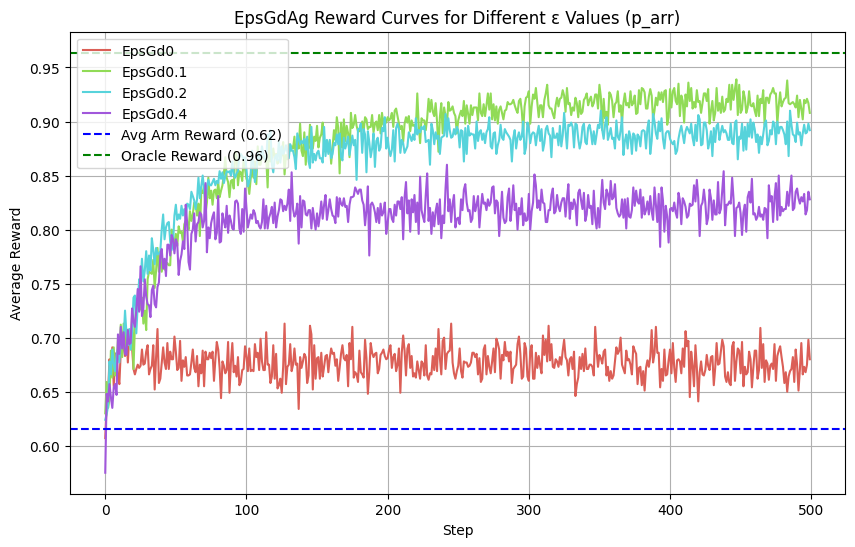

In [20]:
# %% [code]
epsilons = [0, 0.1, 0.2, 0.4]
agents = [EpsGdAg(n_act=len(p_arr), eps=eps) for eps in epsilons]
labels = [f'EpsGd{eps}' for eps in epsilons]

epsgd_logs = mab_swp(agents, p_arr, labels, n_runs=1000, max_steps=500)

# Calculate the average and oracle rewards
avg_reward = np.mean(p_arr)
oracle_reward = np.max(p_arr)

# Plot the reward curves
plt.figure(figsize=(10, 6))
plot_logs(epsgd_logs, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', ci=None)

# Add horizontal lines for average and oracle rewards
plt.axhline(avg_reward, color='blue', linestyle='--', label=f'Avg Arm Reward ({avg_reward:.2f})')
plt.axhline(oracle_reward, color='green', linestyle='--', label=f'Oracle Reward ({oracle_reward:.2f})')

# Set plot titles and labels
plt.title("EpsGdAg Reward Curves for Different ε Values (p_arr)")
plt.xlabel("Step")
plt.ylabel("Average Reward")
plt.legend()
plt.grid(True)
plt.show()

**Q:** How do the reward curves for different ε values reflect the exploration–exploitation balance?  

**A:** The 0 epsilon is the worst because it's greedy only. Also the higher the epsilon goes, the more it chooses suboptimal actions in the later phases which is unnecessary. So the average reward of the 0.1 ep is better than the average reward of the higher ones.

------------------

**Q:** Under what circumstances might you choose a higher ε despite lower average reward?

**A:** A higher ε might be chosen in early phases or when exploring an uncertain environment, where learning about the action space is more important than immediate reward. It can also be useful in scenarios with a short horizon, where you want to ensure diverse exploration to avoid getting stuck in suboptimal solutions.


## Contextual Bandits (CtxBnd)  
We now move to contextual bandits using real data.  
Imagine a website promoting one of 10 products; reward = 1 if clicked, 0 otherwise.  
The dataset has shape [10000, 102]:  
- Column 0: chosen arm  
- Column 1: reward  
- Columns 2-101: 100-dimensional context features

In [21]:
# %% [code]
# Download the dataset (if not already downloaded)
!wget -q http://www.cs.columbia.edu/~jebara/6998/dataset.txt -O dataset.txt

In [22]:
# Load the dataset
ctxData = np.loadtxt("dataset.txt")

# Confirm the shape
print("Dataset shape:", ctxData.shape)

Dataset shape: (10000, 102)


In [23]:
ctxData

array([[ 2.,  0.,  5., ..., 30.,  4.,  0.],
       [ 8.,  0.,  1., ...,  0.,  0., 10.],
       [ 5.,  0.,  3., ...,  3.,  0.,  0.],
       ...,
       [ 9.,  1., 79., ...,  0.,  0.,  0.],
       [ 4.,  0., 29., ..., 17.,  0.,  0.],
       [ 4.,  0.,  0., ...,  0.,  0., 12.]])

In [24]:
# %% [code]
@dataclass
class CtxBnd_Env:
    data: any
    t: int = 0

    def step(self, act):
        if act == self.data[self.t, 0]:
            rew = self.data[self.t, 1]
        else:
            rew = None
        self.t += 1
        return rew

    def reset(self):
        self.t = 0

## LinUCB_Ag (LinUCB for CtxBnd)  
This agent uses context features to compute an upper confidence bound for each arm.

In [25]:
@dataclass
class LinUCB_Ag:
    n_act: int      # number of arms
    alpha: float    # exploration parameter
    feat_dim: int   # dimension of the context features

    def __post_init__(self):
        self.reset()

    def reset(self):
        # Initialize A matrices and b vectors for each arm
        self.As = [np.eye(self.feat_dim) for _ in range(self.n_act)]
        self.bs = [np.zeros((self.feat_dim, 1)) for _ in range(self.n_act)]

    def get_ucb(self, a, state):
        x = state.reshape(-1, 1)
        A_inv = np.linalg.inv(self.As[a])
        theta = A_inv @ self.bs[a]
        est_reward = (x.T @ theta).item()
        uncertainty = self.alpha * np.sqrt((x.T @ A_inv @ x).item())
        p = est_reward + uncertainty
        return p

    def update_params(self, a, rew, state):
        if rew is None:
            return
        x = state.reshape(-1, 1)
        self.As[a] += x @ x.T
        self.bs[a] += rew * x

    def get_action(self, state):
        p_est = [self.get_ucb(a, state) for a in range(self.n_act)]
        return np.argmax(p_est) + 1

**Q:** How does LinUCB leverage context to outperform classical bandit algorithms?  

**A:** We have a separate linear regression estimator for each arm that learns to linearly combine the context of the current user. Therefore, it uses more information than the classical bandit algorithms that have no difference in their action selection in time.

------------------

**Q:** What is the role of the α parameter in LinUCB, and how does it affect the exploration bonus?

**A:** The α parameter controls how much extra weight is given to trying out uncertain options. A higher α means the algorithm will explore more, while a lower α gives less importance to the uncertainity of arms and have less exploration.

In [26]:
# %% [code]
@dataclass
class CtxBnd_Eng:
    data: any
    agent: any

    def __post_init__(self):
        self.env = CtxBnd_Env(data=self.data)

    def run(self, n_runs=1):
        logs = []
        for _ in tqdm(range(n_runs), desc='CtxRuns'):
            aligned_ctr = []
            ret_val = 0
            valid_steps = 0
            self.env.reset()
            self.agent.reset()
            for t in tqdm(range(self.data.shape[0]), desc='Time'):
                state = self.data[t, 2:]
                act = self.agent.get_action(state=state)
                rew = self.env.step(act)
                self.agent.update_params(act - 1, rew, state=state)
                # print(f'Step {t}: {act}, {rew}')
                if rew is not None:
                    ret_val += rew
                    valid_steps += 1
                    aligned_ctr.append(ret_val / float(valid_steps))
            logs.append(pd.DataFrame({'aligned_ctr': aligned_ctr, 'step': np.arange(len(aligned_ctr))}))

        return pd.concat(logs, ignore_index=True)

In [27]:
# %% [code]
def ctxBnd_swp(alphas, data, n_runs=2000):
    logs = []
    for alpha in tqdm(alphas, desc="Alpha Sweeps"):
        agent = LinUCB_Ag(n_act=10, feat_dim=100, alpha=alpha)
        eng = CtxBnd_Eng(data=data, agent=agent)
        log_df = eng.run(n_runs)
        log_df['alpha'] = alpha
        logs.append(log_df)
    return pd.concat(logs, ignore_index=True)


In [28]:
print("Running LinUCB sweep (Simple version)...")
logs_ctx = ctxBnd_swp(alphas=[0, 0.01, 0.1, 0.5], data=ctxData, n_runs=1)

Running LinUCB sweep (Simple version)...


Alpha Sweeps:   0%|          | 0/4 [00:00<?, ?it/s]

CtxRuns:   0%|          | 0/1 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

CtxRuns:   0%|          | 0/1 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

CtxRuns:   0%|          | 0/1 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

CtxRuns:   0%|          | 0/1 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

<ipython-input-2-cea5b34d9fd8>:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(x=x_key, y=y_key, data=df, hue=legend_key, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subs

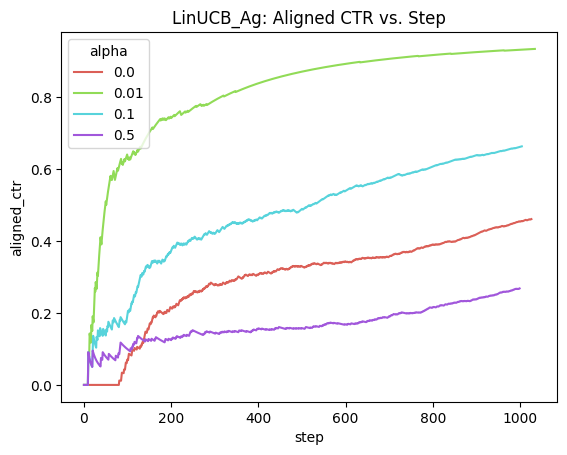

In [29]:
# %% [code]
plot_logs(logs_ctx, x_key='step', y_key='aligned_ctr', legend_key='alpha', estimator='mean', ci=None)
plt.title("LinUCB_Ag: Aligned CTR vs. Step")
plt.show()

**Q:** What does **α** affect in LinUCB?  

**A:** I explained what it does in the last question. The alpha=0 is the simple greedy algorithm which chooses the best xT@theta . By increasing it we choose more actions that we are uncertain about and explore more.

------------------

**Q:** Do the reward curves change with **α**? Explain why or why not.

**A:** They do. The alpha=0 is the simple greedy algorithm which chooses the best xT@theta. It has 0 reward until a positive reward is obtained from the environment and it exploits that only. Also 0.5 and 0.1 are worse than 0.01 by far. Seems like alpha=0.01 is the best choice that balances exploration and exploitation.

**Q:** Based on your experiments, does LinUCB outperform the standard UCB algorithm? Why or why not?

**A:** The two algorithms were not compared on a similar environment so the comparison is not possible. But the LinUCB is kind of a generalized and more powerful algorithm than the standard UCB because it considers N dimensional state and theta, and it optimizes N values per action, not 1 (mean).

------------------

**Q:** What are the key limitations of each algorithm, and how would you choose between them for a given application?

**A:** Classical bandits (like epsilon-greedy or UCB) don’t use context, so they can perform poorly when different situations call for different actions. LinUCB, while better with context, assumes a linear relationship between context and reward, which might not always be true. If your problem has useful side information and you think reward depends on it in a simple way, LinUCB is a good choice. If there’s no context or it's hard to model, classical bandits may be enough.

# Some final question
## Finite‑Horizon Regret and Asymptotic Guarantees:
Question:
Many algorithms (e.g., UCB) are analyzed using asymptotic (long‑term) regret bounds. In a finite‑horizon scenario (say, 500–1000 steps), explain intuitively why an algorithm that is asymptotically optimal may still yield poor performance. What trade‑offs arise between aggressive early exploration and cautious long‑term learning?
Deep Dive:
Discuss how the exploration bonus, tuned for asymptotic behavior, might delay exploitation in finite time, leading to high early regret despite eventual convergence.

An algorithm that is asymptotically optimal might still perform poorly in a short run because its design focuses on long-term performance. It uses an exploration bonus that forces it to keep trying out less-known options to guarantee good performance over an infinite horizon. In a finite setting of 500–1000 steps, this means it may delay exploiting the best option it has already found, resulting in high early regret. The trade-off here is between aggressive early exploration—which can discover the best arm in the long run—and a more cautious approach that exploits early information to minimize short-term losses but risks missing the optimal arm if early data is misleading.


## Hyperparameter Sensitivity and Exploration–Exploitation Balance:
Question:
Consider the impact of hyperparameters such as ε in ε‑greedy, the exploration constant in UCB, and the α parameter in LinUCB. Explain intuitively how slight mismatches in these parameters can lead to either under‑exploration (missing the best arm) or over‑exploration (wasting pulls on suboptimal arms). How would you design a self‑adaptive mechanism to balance this trade‑off in practice?
Deep Dive:
Provide insight into the “fragility” of these parameters in finite runs and how a meta‑algorithm might monitor performance indicators (e.g., variance in rewards) to adjust its exploration dynamically.

Slight mismatches in these hyperparameters can easily ruin the balance between exploring enough to find the best arm and exploiting what you already know. For example, in ε‑greedy if ε is too low, the algorithm might not try enough different arms and miss the best one. Conversely, if ε is too high, it wastes many pulls on suboptimal arms. The same goes for the exploration constant in UCB and the α parameter in LinUCB: too low means the algorithm may settle too quickly on an option that appears best early on, while too high causes it to keep exploring arms that aren’t promising.

One way to design a self‑adaptive mechanism is to let a meta‑algorithm monitor performance indicators such as the variance of rewards. If the variance in rewards is high or improvement stalls, the algorithm could increase the exploration parameter to gather more data.

## Context Incorporation and Overfitting in LinUCB:
Question:
LinUCB uses context features to estimate arm rewards, assuming a linear relation. Intuitively, why might this linear assumption hurt performance when the true relationship is complex or when the context is high‑dimensional and noisy? Under what conditions can adding context lead to worse performance than classical (context‑free) UCB?
Deep Dive:
Discuss the risk of overfitting to noisy or irrelevant features, the curse of dimensionality, and possible mitigation strategies (e.g., dimensionality reduction or regularization).

LinUCB assumes a simple linear link between context and rewards. When the real relationship is complex or the context is high‑dimensional and noisy, the algorithm may overfit to noise and ignore important nonlinear patterns. In these cases, using context can actually mislead the model, making it perform worse than a context‑free UCB that relies solely on observed rewards. Using techniques like dimensionality reduction can help the curse of dimensionality, or regularization can help. But if the true relation is too complex, a more complex model may be needed.

## Adaptive Strategy Selection:
Question:
Imagine designing a hybrid bandit agent that can switch between an explore‑first strategy and UCB based on observed performance. What signals (e.g., variance of reward estimates, stabilization of Q‑values, or sudden drops in reward) might indicate that a switch is warranted? Provide an intuitive justification for how and why such a meta‑strategy might outperform either strategy alone in a finite‑time setting.
Deep Dive:
Explain the challenges in detecting when exploration is “enough” and how early exploitation might capture transient improvements even if the long‑term guarantee favors UCB.

A hybrid agent could start with explore‑first to quickly sample all arms, then switch to UCB once certain signals suggest it's time—like when Q-values (estimated rewards) stop changing much, reward variance drops, or reward rates stabilize. These signs mean the agent has likely learned enough about each arm to make smarter choices.

This kind of meta‑strategy can outperform pure explore‑first or pure UCB in short runs by avoiding too much early exploration or too slow exploitation. But it’s hard to decide when exploration is enough. If you switch too early, you might lock into a suboptimal arm; too late, and you waste steps.


## Non‑Stationarity and “Forgetting” Mechanisms:
Question:
In non‑stationary environments where reward probabilities drift or change abruptly, standard bandit algorithms struggle because they assume stationarity. Intuitively, explain how and why a “forgetting” or discounting mechanism might improve performance. What challenges arise in choosing the right decay rate, and how might it interact with the exploration bonus?
Deep Dive:
Describe the delicate balance between retaining useful historical information and quickly adapting to new trends, and the potential for “chasing noise” if the decay is too aggressive.

To adapt to these scenarios we need to forget about the older data with methods like updating the average estimate using a fixed learning rate α (instead of 1/n). But if α is too high, the agent might react too strongly to random fluctuations and end up “chasing noise.” On the other hand, if α is too low, it won’t adapt quickly enough to changes and will keep relying on outdated information.

This balance is tricky—too much memory slows adaptation, too little memory increases instability. The decay rate also affects how the exploration bonus works: if the algorithm forgets too quickly, uncertainty stays high, which can lead to over-exploration. A well-tuned decay helps the agent stay responsive while still learning stable reward estimates.

## Exploration Bonus Calibration in UCB:
Question:
The UCB algorithm adds a bonus term that decreases with the number of times an arm is pulled. Intuitively, why might a “conservative” (i.e., high) bonus slow down learning—even if it guarantees asymptotic optimality? Under what circumstances might a less conservative bonus be beneficial, and what risks does it carry?
Deep Dive:
Analyze how a high bonus may force the algorithm to continue sampling even when an arm’s estimated reward is clearly suboptimal, thereby delaying convergence. Conversely, discuss the risk of prematurely discarding an arm if the bonus is too low.

A high bonus in UCB makes the algorithm explore more by favoring less‑tried arms longer. While this helps guarantee long‑term learning, it can slow things down in the short term—especially if some arms are clearly worse but still get pulled due to their big bonus. This delays focusing on the best arms.

A lower bonus helps the algorithm settle faster, which can be better in finite settings. But the risk is that it might stop exploring too early and miss a good arm that looked bad just due to early randomness. The key trade‑off is between learning thoroughly and acting quickly.

## Exploration Phase Duration in Explore‑First Strategies:
Question:
In the Explore‑First agent (ExpFstAg), how does the choice of a fixed exploration period (e.g., 5 vs. 20 steps) affect the regret and performance variability? Provide a scenario in which a short exploration phase might yield unexpectedly high regret, and another scenario where a longer phase might delay exploitation unnecessarily.
Deep Dive:
Discuss how the “optimal” exploration duration can depend heavily on the underlying reward distribution’s variance and the gap between the best and other arms, and why a one‑size‑fits‑all approach may not work in practice.

In Explore‑First, a short exploration phase (like 5 steps) might not give enough data to identify the best arm, especially if rewards are noisy or close together. This can lead to high regret if the agent commits to a bad arm too early. On the other hand, a long exploration (like 20 steps) wastes pulls on suboptimal arms even after it's clear which one is best, slowing down reward collection.

The best exploration length depends on how different the arms are (reward gaps) and how noisy the rewards are. If rewards are similar or highly variable, you need more exploration. That’s why fixed-length exploration doesn’t always work well—you need something adaptive to the problem.

## Bayesian vs. Frequentist Approaches in MAB:
Question:
Compare the intuition behind Bayesian approaches (such as Thompson Sampling) to frequentist methods (like UCB) in handling uncertainty. Under what conditions might the Bayesian approach yield superior practical performance, and how do the underlying assumptions about prior knowledge influence the exploration–exploitation balance?
Deep Dive:
Explore the benefits of incorporating prior beliefs and the risk of bias if the prior is mis-specified, as well as how Bayesian updating naturally adjusts the exploration bonus as more data is collected.

Bayesian methods like Thompson Sampling handle uncertainty by keeping a full distribution over reward estimates and sampling from it to make decisions. This leads to more natural, data-driven exploration. Frequentist methods like UCB, on the other hand, use fixed formulas (like upper bounds) to decide how uncertain they are.

Bayesian methods often perform better in practice when you have good prior knowledge or when data is limited, since they can guide exploration more effectively. But if the prior is wrong, it can bias the agent and slow learning. One advantage is that Bayesian updates automatically reduce uncertainty as more data comes in, adjusting exploration over time without needing manual tuning like UCB does.


## Impact of Skewed Reward Distributions:
Question:
In environments where one arm is significantly better (skewed probabilities), explain intuitively why agents like UCB or ExpFstAg might still struggle to consistently identify and exploit that arm. What role does variance play in these algorithms, and how might the skew exacerbate errors in reward estimation?
Deep Dive:
Discuss how the variability of rare but high rewards can mislead the agent’s estimates and cause prolonged exploration of suboptimal arms.

The problem is that these algorithms have a preset exploration amount so even in a clear and skewed scenario where the winner is obvious and they must exploit, they continue exploring.
Even when one arm is clearly better, algorithms like UCB or Explore‑First can struggle if the rewards are noisy. If the best arm happens to get unlucky early on—like missing clicks or low payouts—it might look worse than it really is. At the same time, a worse arm could get lucky and seem better.

## Designing for High-Dimensional, Sparse Contexts:
Question:
In contextual bandits where the context is high-dimensional but only a few features are informative, what are the intuitive challenges that arise in using a linear model like LinUCB? How might techniques such as feature selection, regularization, or non-linear function approximation help, and what are the trade-offs involved?
Deep Dive:
Provide insights into the risks of overfitting versus underfitting, the increased variance in estimates from high-dimensional spaces, and the potential computational costs versus performance gains when moving from a simple linear model to a more complex one.

High dimensional and sparse data lead to overfitting to specific features and wrong estimations since the data is sparse. As we know from machine learning concepts, it is good to use dimesionality reduction or fature selection to avoid complex high dimensional models' overfitting probelm. But if we reduce the dimension too much, we might lose important signals and end up underfitting, where the model becomes too simple to capture the useful patterns. Linear models like LinUCB assume all features matter equally, but in high-dimensional settings, only a few might actually be relevant. This makes it harder to learn accurate reward estimates.

Using feature selection or regularization (like ridge regression) helps focus on the most useful features and control variance. Non-linear models (like neural networks) can also capture more complex patterns, but they bring extra computation and risk of overfitting if not carefully tuned. So, it's always a balance between model complexity, generalization, and runtime.

